In [9]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import astropy.units.imperial as ui 
import os 
from pyXSteam.XSteam import XSteam
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, FormatStrFormatter
from math import pi

ui.enable()
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

if not os.path.exists('figs'): 
    os.mkdir('figs')

from helper import print_value
g_c = 32.17 * ui.lbm * ui.ft / (u.s**2 * ui.lbf) 
g = 32.17 * ui.ft / u.s**2

Reactor Params

In [10]:
from helper import calc_Ax, calc_De, calc_sg_location
steamTable = XSteam(XSteam.UNIT_SYSTEM_FLS)
P_c = 22060 * u.kPa
Qdot = 3976 * u.MW
gamma_f = 0.974
P = 1040 * ui.psi
T_fd = 410 * ui.deg_F
F_q = 3.15 
F_z = 1.45 
H_f = (178 * ui.inch).to(ui.ft)
D = (0.4039 * ui.inch).to(ui.ft)
D_i = (0.3441 * ui.inch).to(ui.ft)
D_f = (0.3386 * ui.inch).to(ui.ft)
S = (0.5098 * ui.inch).to(ui.ft)
k_c = 9.6 * ui.BTU / (u.h * ui.ft * ui.deg_F)
H_g = 1200 * ui.BTU / (u.h * ui.ft**2 * ui.deg_F)
n_a = 872 
n_fr_a = 92 
n = n_a * n_fr_a 
n_w = 8 
N_sg = 8 
K_sg = 0.6 
K_in = 1.5 
K_out = 1.0 
K_dc = 2.5
V_d = (280 * ui.inch).to(ui.ft)
C_d = (184 * ui.inch).to(ui.ft)
H_c = 12 * ui.ft 
Ax = calc_Ax(S, D)
De = calc_De(Ax, D)
CPR = 1.28
dz = 1e-2 * ui.ft 
z_range = np.arange(0, H_f.value, dz.value) * ui.ft 
sg_locations = calc_sg_location(N_sg, H_f)
sg_idx = np.zeros(sg_locations.size, int)
K_array = np.zeros((2 + N_sg, ))
K_array[0] = K_in 
K_array[-1] = K_out 
K_array[1:-1] = K_sg 
CPR_goal = 1.28 

Constant Fluid Properties

In [11]:
h_f = steamTable.hL_p(P.value) * ui.BTU / ui.lbm
h_g = steamTable.hV_p(P.value) * ui.BTU / ui.lbm
h_fg = h_g - h_f
h_fd = steamTable.h_pt(P.value, T_fd.value) * ui.BTU / ui.lbm
rho_f = steamTable.rhoL_p(P.value) * ui.lbm / ui.ft**3 
rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
mu_f = steamTable.my_ph(P.value, h_f.value) * ui.lb / (ui.ft * u.h)
mu_g = steamTable.my_ph(P.value, h_g.value) * ui.lb / (ui.ft * u.h)

mdot_fd = (Qdot / (h_g - h_fd)).to(ui.lbm / u.hr)
print_value('mdot_fd', mdot_fd)

mdot_fd = 1.686826E+07 lb / h


Finding the spacer grid indicies 

In [12]:
for i in range(sg_locations.size): 
    sg_idx[i] = int(np.where(z_range.value <= sg_locations[i].value)[0][-1])

Extrapolated Distance

i = 2028757
i = 2028758
Omega = 2.02876


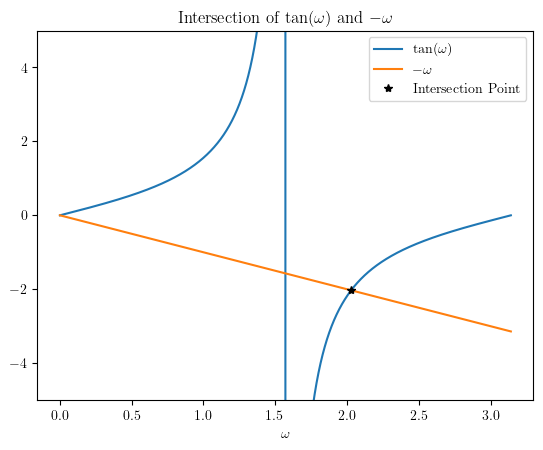

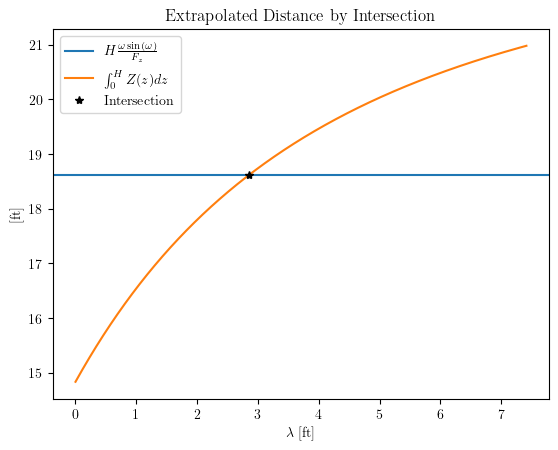

lambda = 2.853000E+00 ft


In [13]:
from helper import find_lambda, int_shape, print_value
lambda_, omega = find_lambda(D, H_f, F_z)

In [14]:
qpp_bar = ((gamma_f * Qdot) / (n * pi * D * H_f * omega * np.sin(omega))).to(ui.BTU / (ui.ft**2 * u.hr))
qpp_hot = F_q * qpp_bar 

In [15]:

def martinelli_multiplier(x, mu_f, mu_g, rho_f, rho_g):
    if x <= 0: 
        return 1

    chi_2 = (mu_f / mu_g)**(0.2) * ((1 - x) / x)**1.8 * (rho_g / rho_f)
    chi = np.sqrt(chi_2)
    phi_2 = (1 + (20 / chi) + (1 / chi_2)) * (1 - x)**(1.8)
    return phi_2

def homogeneous_multiplier(x, rho_l, rho_f, rho_g): 
    if x <= 0: 
        return 1 
    v_f = 1 / rho_f
    v_lg = (1 / rho_g) - (1 / rho_l)
    term1 = rho_f / rho_l 
    term2 = 0 
    if x > 0: 
        term2 = v_lg / v_f * x
    return term1 + term2 


def calc_b(rho_l, P): 
    rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
    return (rho_g / rho_l)**(0.1)

def calc_beta(x, rho_l, P): 
    rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
    return x / (x + (1 - x) * rho_g / rho_l)

def calc_V_gj(rho_l, P): 
    rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
    sigma = steamTable.st_p(P.value) * ui.lbf / ui.ft
    g_c = 32.17 * ui.lbm * ui.ft / (u.s**2 * ui.lbf) 
    g = 32.17 * ui.ft / u.s**2
    numer = sigma * g * g_c * (rho_l - rho_g) 
    denom = rho_l**2 
    return 2.9 * (numer / denom)**(1/4)

def calc_C_0(beta, b): 
    return beta * (1 + ((1 / beta) - 1))**b

def alpha_zuber_findlay(x, rho_l, G, P): 
    alpha = np.zeros(x.shape)
    idx = np.where(x > 0)
    rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
    valid_x = x[idx]
    valid_rho_l = rho_l[idx]
    b = calc_b(valid_rho_l, P)
    beta = calc_beta(valid_x, valid_rho_l, P)
    V_gj = calc_V_gj(valid_rho_l, P)
    C_0 = calc_C_0(beta, b)

    term1 = (1 - valid_x) / valid_x * (rho_g / valid_rho_l)
    term2 = rho_g * V_gj / (G * valid_x)
    denom = C_0 * (1 + term1) + term2 
    alpha_valid = 1 / denom

    alpha[idx] = alpha_valid
    return alpha 

def detlaP_f_norm(f, D_e, x_bar, mu_f, mu_g, rho_f, rho_g, H_0, H_f): 
    multiplier = martinelli_multiplier(x_bar, mu_f, mu_g, rho_f, rho_g)
    return (f / D_e) * (1 / (2 * rho_f)) * (H_0 + (H_f - H_0) * multiplier)

def deltaP_local_norm(rho_l_array, rho_f, rho_g, K_array, x_array): 
    multipliers = np.zeros(K_array.shape)

    for i in range(x_array.size): 
        multipliers[i] = homogeneous_multiplier(x_array[i], rho_l_array[i], rho_f, rho_g)
    return (1 / (2 * rho_f)) * np.sum(K_array * multipliers)

def delatP_elev(rho_bar, H_c): 
    return rho_bar * g / g_c * H_c 

def dP_from_G(G, f, D_e, H_0, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array): 
    dP_f_norm = detlaP_f_norm(f, D_e, x_bar, mu_f, mu_g, rho_f, rho_g, H_0, H_f)
    dP_local_norm = deltaP_local_norm(rho_l_array, rho_f, rho_g, K_array, x_array)
    dP_part = (G**2 / g_c) * (dP_f_norm + dP_local_norm)
    dP_elev = delatP_elev(rho_bar, H_c)
    dP = (dP_part + dP_elev).to(ui.psi)
    return dP

def G_from_DP(deltaP, f, D_e, H_0, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array): 
    dP_f_norm = detlaP_f_norm(f, D_e, x_bar, mu_f, mu_g, rho_f, rho_g, H_0, H_f)
    dP_local_norm = deltaP_local_norm(rho_l_array, rho_f, rho_g, K_array, x_array)
    dP_norm = dP_f_norm + dP_local_norm
    dP_elev = delatP_elev(rho_bar, H_c)
    G = np.sqrt((g_c * deltaP - dP_elev) / (dP_norm))
    G = G.to(ui.lbm / (ui.ft**2 * u.hr))
    return G 
    
def x_e(h, h_f, h_fg): 
    return (h - h_f) / h_fg 

Calculating the mass flux in the average channel 

In [16]:
from helper import calc_Re, friction_factor, calc_h_bar, non_boiling_height_BOC_CISE_4, enthalpy_profile, qpp_crit_CISE_4
deltaP = 50 * ui.psi 

# dummy starting values 
e = 1e-5
H_0_curr = 1 * ui.ft 

f = 1.2e-2
x_bar = 0 
rho_bar = rho_f
rho_l_array = rho_f * np.ones(K_array.shape)
x_array = np.zeros(K_array.shape)
G_curr = G_from_DP(deltaP, f, De, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array)

CPR_curr = 0 
while CPR_curr < CPR_goal:
    G_prev = 0 * G_curr.unit 
    deltaP_curr = 0 * deltaP.unit
    while np.abs((G_curr - G_prev).value) >= e and np.abs((deltaP_curr - deltaP).value) >= e: 
        mdot_curr = G_curr * Ax 

        deltaP_curr = dP_from_G(G_curr, f, De, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array)

        # updating the core inlet enthalpy     
        h_in = (mdot_fd / (n * mdot_curr)) * h_fd + (1 - (mdot_fd / (n * mdot_curr))) * h_f 
        T_in = steamTable.t_ph(P.value, h_in.value) * ui.deg_F 
        # updating the core average enthalpy 
        h_bar = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_bar, H_f, lambda_)
        # updating the core average density 
        rho_bar = steamTable.rho_ph(P.value, h_bar.value) * ui.lbm / ui.ft**3 
        # updating friction factor 
        Re = calc_Re(G_curr, D, mu_f)
        f = friction_factor(Re)
        # updating the non boiling height 
        H_0_curr = non_boiling_height_BOC_CISE_4(D, G_curr, P, P_c, H_f, lambda_, T_in, De, D, int_shape)
        # updating the quality at the average boiling height 
        H_b_bar = ((H_f - H_0_curr) / 2) + H_0_curr
        h_b_bar = enthalpy_profile(H_b_bar, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        x_bar = x_e(h_b_bar, h_f, h_fg)
        # updating the inlet density and quality 
        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        G_prev = G_curr 
        G_curr = G_from_DP(deltaP, f, De, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array)
    G_bar = G_curr 
    H_0 = H_0_curr

    # resetting the stopping conditions to calculte the pressure drop in the hot channel 
    deltaP_curr = 0 * deltaP.unit
    G_prev = 0 * G_curr.unit 
    while np.abs((G_curr - G_prev).value) >= e and np.abs((deltaP_curr - deltaP).value) >= e: 
        mdot_curr = G_curr * Ax 

        deltaP_curr = dP_from_G(G_curr, f, De, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array)
        # updating the average enthalpy 
        h_bar = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_hot, H_f, lambda_)
        # updating the average density 
        rho_bar = steamTable.rho_ph(P.value, h_bar.value) * ui.lbm / ui.ft**3 
        # updating friction factor 
        Re = calc_Re(G_curr, D, mu_f)
        f = friction_factor(Re)

        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        G_prev = G_curr 
        G_curr = G_from_DP(deltaP, f, De, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, x_array)

        G_hot = G_curr 

    # checking the critical power ratio 
    mdot_hot = G_hot * Ax
    qpp_crit = qpp_crit_CISE_4(gamma_f, mdot_hot, h_f, h_in, D, H_0, H_f, lambda_, int_shape)
    CPR_curr = qpp_crit / qpp_hot 
    if CPR_curr < CPR_goal: 
        deltaP = deltaP + 1 * ui.psi
print_value('deltaP', deltaP)
print(G_hot)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         1.         1.         1.22556866 1.47757995 1.70053376
 1.8809614  2.01255483 2.09606797 2.13863565]
[1.         1.         1.         1.22556866 1.47757995 1.70053376
 1.8809614  2.01255483 2.09606797 2.13863565]
[1.         1.         1.         1.32439849 1.68578208 2.00456185
 2.26188293 2.44918304 2.56788344 2.62833657]
[1.         1.         1.         1.32439849 1.68578208 2.00456185
 2.26188293 2.44918304 2.56788344 2.62833657]
[1.         1.         1.         1.36294826 1.76681983 2.12266768
 2.40962189 2.61832589 2.75051747 2.81781943]
[1.         1.         1.         1.36294826 1.76681983 2.12266768
 2.40962189 2.61832589 2.75051747 2.81781943]
[1.         1.         1.         1.37686579 1.7960526  2.16524012
 2.46284284 2.67922922 2.81625908 2.88601599]
[1.         1.         1.         1.37686579 1.7960526  2.16524012
 2.46284284 2.67922922 2.81625908 2.88601599]
[1.         1.         1.       

Calculating the mass flux in the hot channel 